In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt


In [11]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [2]:
df=pd.read_csv("heart.csv")
df.head(5)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output'],
      dtype='object')

In [3]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

In [4]:
cols = df.columns

In [5]:
for col in cols:
    print(col, ":", df[col].nunique())

age : 41
sex : 2
cp : 4
trtbps : 49
chol : 152
fbs : 2
restecg : 3
thalachh : 91
exng : 2
oldpeak : 40
slp : 3
caa : 5
thall : 4
output : 2


In [6]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
num_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]

In [7]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
len(df_train), len(df_test)

(242, 61)

In [8]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.output.values
y_test = df_test.output.values

del df_train['output']
del df_test['output']

In [9]:
from sklearn.feature_extraction import DictVectorizer

dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

# Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [11]:
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-10,10,2),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

model_logreg = LogisticRegression()

In [113]:
scorings_list = ['accuracy', 'f1', 'roc_auc']
for scoring in scorings_list:
    clf = GridSearchCV(model_logreg,
                       param_grid = parameters,
                       scoring=scoring,
                       cv=10) 
    clf.fit(X_train,y_train)
    print("Tuned Hyperparameters :", clf.best_params_)
    print(f"{scoring} :",clf.best_score_)
    print("________________________")

Tuned Hyperparameters : {'C': 10000000000.0, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8516666666666666
________________________
Tuned Hyperparameters : {'C': 10000000000.0, 'penalty': 'l2', 'solver': 'lbfgs'}
f1 : 0.8725802150718724
________________________
Tuned Hyperparameters : {'C': 10000000000.0, 'penalty': 'l2', 'solver': 'lbfgs'}
roc_auc : 0.9257692307692308
________________________


In [13]:
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())

# Random Forest

In [91]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, accuracy_score

In [18]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = []

for train_indices, test_indices in tqdm(kf.split(X_train), total=5):
    scores = []
    
    X_train_kf = X_train[train_indices]
    y_train_kf = y_train[train_indices]

    X_test_kf = X_train[test_indices]
    y_test_kf = y_train[test_indices]
    
    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_
    
    for number_of_trees in tqdm(values, leave=False):
        tuned_forest = RandomForestClassifier(n_estimators=number_of_trees)
        
        tuned_forest.n_classes_ = 2
        tuned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_test_kf, tuned_forest.predict_proba(X_test_kf)[:, 1]))
    
    scores = np.array(scores)
    
    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

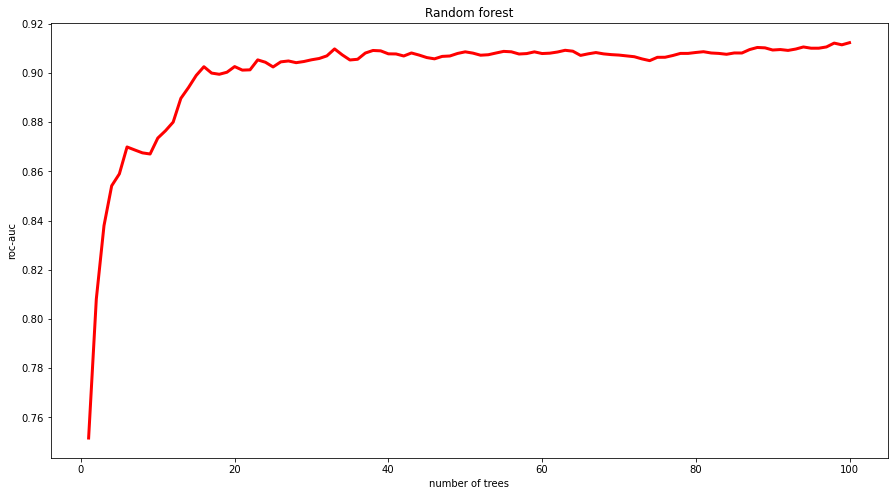

In [20]:
mean_cross_val_score = global_scores.mean(axis=0)

plt.figure(figsize=(15,8))
plt.title('Random forest')

plt.plot(values, 
         mean_cross_val_score, 
         label='mean values', 
         color='red', 
         lw=3)

plt.xlabel('number of trees')
plt.ylabel('roc-auc')
plt.show()

# Tuned Random Forest

In [25]:
from sklearn.model_selection import RandomizedSearchCV

In [118]:
grid = { 
    'n_estimators': np.linspace(100,1000,10, dtype=int),
    'max_features': ['sqrt', 'log2', 'auto'],
    'max_depth' : np.linspace(1,100,1),
    'criterion' :['gini', 'entropy']
}
rf_cv = GridSearchCV(estimator=RandomForestClassifier(), param_grid=grid, scoring='roc_auc',cv= 5)
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([1.]),
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='roc_auc')

In [121]:
rf_cv.best_params_, rf_cv.best_score_

({'criterion': 'gini',
  'max_depth': 1.0,
  'max_features': 'sqrt',
  'n_estimators': 300},
 0.9156843156843157)

In [131]:
# rf_best = RandomForestClassifier(criterion='gini',max_depth=65,max_features='sqrt',n_estimators=200)
rf_best = RandomForestClassifier(criterion='gini',max_depth=1,max_features='sqrt',n_estimators=300)
rf_best.fit(X_train, y_train)

dv = DictVectorizer(sparse=False)
test_dict = df_test.to_dict(orient='records')
X_test = dv.fit_transform(test_dict)

y_pred = rf_best.predict(X_test)
print("roc_auc_score",roc_auc_score(y_pred, y_test))
print("accuracy_score",accuracy_score(y_pred, y_test))

roc_auc_score 0.7683066361556065
accuracy_score 0.7540983606557377


# Pickle

In [132]:
import pickle


In [134]:
output_file = 'model.bin'

In [135]:
f_out = open(output_file,'wb')
pickle.dump((dv, rf_best),f_out)
f_out.close()

In [1]:
import pickle

In [2]:
model_file = 'model.bin'

In [3]:
with open (model_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [4]:
dv, model

(DictVectorizer(sparse=False),
 RandomForestClassifier(max_depth=1, max_features='sqrt', n_estimators=300))

In [5]:
analysis = {
    'age':13,
    'sex':1,
    'cp':3,
    'trtbps':145,
    'chol':233,
    'fbs':1,
    'restecg':0,
    'thalachh':150,
    'exng':0,
    'oldpeak':2.3,
    'slp':0,
    'caa':0,
    'thall':1,
    'output':1

}

In [8]:
X = dv.transform(analysis)

In [11]:
model.predict_proba(X)[0,1]

0.6486095686255042